# Imports & Global Configuration

---


This cell sets up the environment, imports necessary libraries, and ensures the results are reproducible.

In [ ]:
# --- Cell 1: Imports and Setup ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog
from scipy import stats
import pandas as pd
import random
import time

# Set device (GPU if available)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# Constants
BATCH_SIZE = 64
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
NUM_CLASSES = len(CLASSES)

Using device: cuda


# Data Loading & Preparation

---


This cell downloads CIFAR-10 and prepares two versions of the data:

*   PyTorch DataLoaders: For the Deep Learning model (Normalized tensors).
*   NumPy Arrays: For Classical ML models (Flattened raw pixel data).









In [ ]:
# --- Cell 2: Data Loading & Preparation ---

# 1. Transformations for Deep Learning (Normalization is crucial for CNNs)

# In Cell 2, update the dl_transform:
dl_transform = transforms.Compose([
    # Add Augmentations for Training Set ONLY
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),

    transforms.ToTensor(),
    # Normalization
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# NOTE: The validation and test sets must NOT use RandomCrop/Flip.
# You must create a separate transformation for the validation/test sets:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Ensure you reload the datasets and DataLoaders in Cell 2 using the correct transforms:
train_ds_dl = datasets.CIFAR10(root='./data', train=True, download=True, transform=dl_transform)
# Use test_transform for the validation/test split:
test_ds_dl = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# 2. Load Datasets
# Train set
train_ds_dl = datasets.CIFAR10(root='./data', train=True, download=True, transform=dl_transform)
train_ds_raw = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor()) # For Classical

# Test set
test_ds_dl = datasets.CIFAR10(root='./data', train=False, download=True, transform=dl_transform)
test_ds_raw = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor()) # For Classical

# 3. Split Test Set into Validation (50%) and Final Test (50%)
test_size = len(test_ds_dl)
val_size = int(0.5 * test_size)
final_test_size = test_size - val_size

# Use a fixed generator for reproducible splits
generator = torch.Generator().manual_seed(42)
val_ds, final_test_ds = torch.utils.data.random_split(test_ds_dl, [val_size, final_test_size], generator=generator)

# Get indices for the raw data split (so Classical ML uses the exact same images for testing)
val_indices = val_ds.indices
test_indices = final_test_ds.indices

# 4. Create DataLoaders (For CNN)
train_loader = DataLoader(train_ds_dl, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
final_test_loader = DataLoader(final_test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Data Loaded: Train({len(train_ds_dl)}), Val({len(val_ds)}), Test({len(final_test_ds)})")

100%|██████████| 170M/170M [00:03<00:00, 48.9MB/s]


Data Loaded: Train(50000), Val(5000), Test(5000)


# Classical Model 1 - HOG + SVM

---


This model uses Histogram of Oriented Gradients (HOG) to extract shape features (edges/gradients) from the images before feeding them into an SVM.

In [ ]:
# --- Cell 3: Classical Model 1 (HOG + SVM)

print("--- Preparing HOG + SVM ---")

def extract_hog_features(dataset, indices=None):
    """Helper to extract HOG features from a dataset."""
    features = []
    labels = []

    # If indices are provided (for test/val splits), use them
    if indices is not None:
        data_source = [dataset[i] for i in indices]
    else:
        data_source = dataset

    print(f"Extracting HOG features for {len(data_source)} images (this may take a moment)...")
    #

    for img_tensor, label in data_source:
        # Convert to numpy (H, W, C) and scale to 0-255 uint8
        img_np = (img_tensor.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)

        # Extract HOG
        fd = hog(img_np, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), channel_axis=-1)
        features.append(fd)
        labels.append(label)

    return np.array(features), np.array(labels)

# 1. Prepare Data
X_train_hog, y_train_hog = extract_hog_features(train_ds_raw)
# For the final test, we only use the 'final_test' split indices we defined in Cell 2
X_test_hog, y_test_hog = extract_hog_features(test_ds_raw, indices=test_indices)

# 2. Scale Features (Important for SVM)
scaler_svm = StandardScaler()
X_train_hog_scaled = scaler_svm.fit_transform(X_train_hog)
X_test_hog_scaled = scaler_svm.transform(X_test_hog)

# 3. Hyperparameter Tuning (GridSearch)
# We use a subset for GridSearch to save time, then train on full data
print("Running GridSearchCV (on subset)...")
param_grid = {'C': [1, 10], 'gamma': ['scale']}
subset_idx = 5000
grid_svm = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=3, n_jobs=-1)
grid_svm.fit(X_train_hog_scaled[:subset_idx], y_train_hog[:subset_idx])
print(f"Best SVM Params: {grid_svm.best_params_}")

# 4. Train Final HOG-SVM Model (using the parameters found above)
print("Training Final HOG-SVM model on full dataset...")
final_svm = SVC(**grid_svm.best_params_, kernel='rbf', random_state=42)
final_svm.fit(X_train_hog_scaled, y_train_hog)
print("HOG-SVM Training Complete.")

--- Preparing HOG + SVM ---
Extracting HOG features for 50000 images (this may take a moment)...
Extracting HOG features for 5000 images (this may take a moment)...
Running GridSearchCV (on subset)...
Best SVM Params: {'C': 10, 'gamma': 'scale'}
Training Final HOG-SVM model on full dataset...
HOG-SVM Training Complete.


# Classical Model 1 - k-NN

---


This model uses the raw pixel values directly. It is simple but computationally heavy at prediction time.

In [ ]:
# --- Cell 4: Classical Model 2 (k-NN) ---

print("--- Preparing k-NN ---")

# 1. Prepare Data (Flatten raw pixels)
# Reshape from (N, 3, 32, 32) -> (N, 3072)
X_train_knn = train_ds_raw.data.reshape(len(train_ds_raw), -1)
y_train_knn = np.array(train_ds_raw.targets)

# Get test data using the indices
X_test_knn = test_ds_raw.data[test_indices].reshape(len(test_indices), -1)
y_test_knn = np.array(test_ds_raw.targets)[test_indices]

# 2. Scale Features
scaler_knn = StandardScaler()
# Convert to float for scaling
X_train_knn_scaled = scaler_knn.fit_transform(X_train_knn.astype(np.float32))
X_test_knn_scaled = scaler_knn.transform(X_test_knn.astype(np.float32))

# 3. Hyperparameter Tuning
print("Running GridSearchCV for k-NN (on subset)...")
# k-NN is slow, so we test small params
param_grid_knn = {'n_neighbors': [3, 7], 'weights': ['distance']}
subset_idx = 5000
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3, n_jobs=-1)
grid_knn.fit(X_train_knn_scaled[:subset_idx], y_train_knn[:subset_idx])
print(f"Best k-NN Params: {grid_knn.best_params_}")

# 4. Train Final Model
# k-NN "training" is just storing data
final_knn = KNeighborsClassifier(**grid_knn.best_params_)
final_knn.fit(X_train_knn_scaled, y_train_knn)
print("k-NN Model Ready.")

--- Preparing k-NN ---
Running GridSearchCV for k-NN (on subset)...
Best k-NN Params: {'n_neighbors': 7, 'weights': 'distance'}
k-NN Model Ready.


# Deep Learning Architecture (CNN)

---


This cell defines the neural network structure using PyTorch

In [ ]:
# --- Cell 3: Advanced Deep Learning (Transfer Learning)
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch

# 1. Load Pre-trained ResNet18
print("Loading pre-trained ResNet18...")
# weights='DEFAULT' loads weights trained on ImageNet
resnet_model = models.resnet18(weights='DEFAULT')

# 2. Modifying the final layer for CIFAR-10 (10 classes instead of 1000)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 10)
resnet_model = resnet_model.to(DEVICE)

# 3. Define Training Function
def train_model_refined(model, train_loader, val_loader, epochs=25): # Adjusted default epochs to 25
    criterion = nn.CrossEntropyLoss()


    optimizer = optim.Adam(model.parameters(), lr=0.0003) # Optimized Learning Rate
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

    best_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    print(f"Starting Fine-Tuning on {DEVICE}...")
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss = 0
        for X, y in train_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation Phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(DEVICE), y.to(DEVICE)
                out = model(X)
                loss = criterion(out, y)
                val_loss += loss.item()
                _, pred = torch.max(out, 1)
                total += y.size(0)
                correct += (pred == y).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        acc = correct / total

        print(f"Epoch {epoch+1}/{epochs} | Val Acc: {acc:.4f} | Val Loss: {avg_val_loss:.4f}")

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(acc)
        scheduler.step(avg_val_loss)

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_resnet.pth')

    model.load_state_dict(torch.load('best_resnet.pth'))
    return model, history

# 4. Train
print("Fine-Tuning ResNet18 on CIFAR-10...")
# Pass the model, loaders, and epochs (25 is the optimized duration)
trained_resnet, resnet_history = train_model_refined(resnet_model, train_loader, val_loader, epochs=25)

Loading pre-trained ResNet18...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


Fine-Tuning ResNet18 on CIFAR-10...
Starting Fine-Tuning on cuda...
Epoch 1/25 | Val Acc: 0.7282 | Val Loss: 0.8037
Epoch 2/25 | Val Acc: 0.7720 | Val Loss: 0.6659
Epoch 3/25 | Val Acc: 0.7732 | Val Loss: 0.6818
Epoch 4/25 | Val Acc: 0.7842 | Val Loss: 0.6290
Epoch 5/25 | Val Acc: 0.8014 | Val Loss: 0.5755
Epoch 6/25 | Val Acc: 0.8056 | Val Loss: 0.5833
Epoch 7/25 | Val Acc: 0.8238 | Val Loss: 0.5371
Epoch 8/25 | Val Acc: 0.8132 | Val Loss: 0.5595
Epoch 9/25 | Val Acc: 0.8272 | Val Loss: 0.5258
Epoch 10/25 | Val Acc: 0.8390 | Val Loss: 0.5084
Epoch 11/25 | Val Acc: 0.8324 | Val Loss: 0.4917
Epoch 12/25 | Val Acc: 0.8332 | Val Loss: 0.4885
Epoch 13/25 | Val Acc: 0.8380 | Val Loss: 0.4934
Epoch 14/25 | Val Acc: 0.8398 | Val Loss: 0.4906
Epoch 15/25 | Val Acc: 0.8418 | Val Loss: 0.4902
Epoch 16/25 | Val Acc: 0.8584 | Val Loss: 0.4292
Epoch 17/25 | Val Acc: 0.8646 | Val Loss: 0.4384
Epoch 18/25 | Val Acc: 0.8680 | Val Loss: 0.4203
Epoch 19/25 | Val Acc: 0.8702 | Val Loss: 0.4127
Epoch 20/2

# Deep Learning Training Loop

---

Deep Feature Extraction for Classical Models
To get SVM/k-NN to 85%, we cannot use raw pixels. We pass the images through the ResNet (minus the last layer) to get high-quality vectors.

In [ ]:
# --- Cell 4: Feature Extraction for Classical Models ---

# Create a feature extractor: ResNet without the final classification layer
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1]) # Remove last layer

    def forward(self, x):
        x = self.features(x)
        return x.flatten(start_dim=1)

print("Extracting Deep Features for Classical Models...")
feature_extractor = FeatureExtractor(trained_resnet).to(DEVICE)
feature_extractor.eval()

def get_deep_features(loader):
    all_features = []
    all_labels = []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(DEVICE)
            feats = feature_extractor(X)
            all_features.append(feats.cpu().numpy())
            all_labels.append(y.numpy())
    return np.concatenate(all_features), np.concatenate(all_labels)

# Extract features using the DataLoaders (this ensures we use the same normalized data)
X_train_deep, y_train_deep = get_deep_features(train_loader)
X_test_deep, y_test_deep = get_deep_features(final_test_loader)

print(f"Deep Features Shape: {X_train_deep.shape}")
# Shape should be (50000, 512) -> Much better than (50000, 3072) raw pixels!

Extracting Deep Features for Classical Models...
Deep Features Shape: (50000, 512)


# Classical Model 2:  SVM

In [ ]:
# --- Cell 5: Train Classical Models on Deep Features---

print("--- Training Classical Models on Deep Features ---")

# 1. SCALE FEATURES (CRITICAL MISSING STEP)
# Deep features must be scaled/normalized for distance-based models (SVM and k-NN).
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_deep)
X_test_scaled = scaler.transform(X_test_deep)
print("   -> Deep Features scaled.")


# 2. Train SVM (Optimized RBF Kernel)
print("3. Training SVM (RBF) on Deep Features...")
# Using RBF kernel with C=5 for strong fitting on complex features.
final_svm = SVC(kernel='rbf', C=5, probability=True, random_state=42)
final_svm.fit(X_train_scaled, y_train_deep)
print("   -> SVM Trained successfully.")

# 3. Train k-NN (Optimized k)
print("4. Training k-NN on Deep Features...")
# Using n_neighbors=5 and 'distance' weighting.
final_knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
final_knn.fit(X_train_scaled, y_train_deep)
print("   -> k-NN Trained successfully (data stored).")

print("--- Classical Model Training Complete ---")

--- Training Classical Models on Deep Features ---
   -> Deep Features scaled.
3. Training SVM (RBF) on Deep Features...
   -> SVM Trained successfully.
4. Training k-NN on Deep Features...
   -> k-NN Trained successfully (data stored).
--- Classical Model Training Complete ---


# Final Evaluation & Comparison

---


This cell gathers results from all three models and produces the final tables and plots.


==================== ResNet-18 (Deep Learning) Detailed Results ====================
Overall Accuracy: 86.26%

--- Classification Report ---
              precision    recall  f1-score   support

       plane     0.8770    0.8770    0.8770       488
         car     0.8812    0.9349    0.9072       476
        bird     0.8633    0.8246    0.8435       536
         cat     0.7297    0.7383    0.7340       512
        deer     0.8426    0.8981    0.8695       471
         dog     0.7827    0.7613    0.7718       511
        frog     0.8968    0.9131    0.9049       495
       horse     0.9002    0.8765    0.8882       494
        ship     0.9275    0.9400    0.9337       517
       truck     0.9318    0.8740    0.9020       500

    accuracy                         0.8626      5000
   macro avg     0.8633    0.8638    0.8632      5000
weighted avg     0.8629    0.8626    0.8624      5000



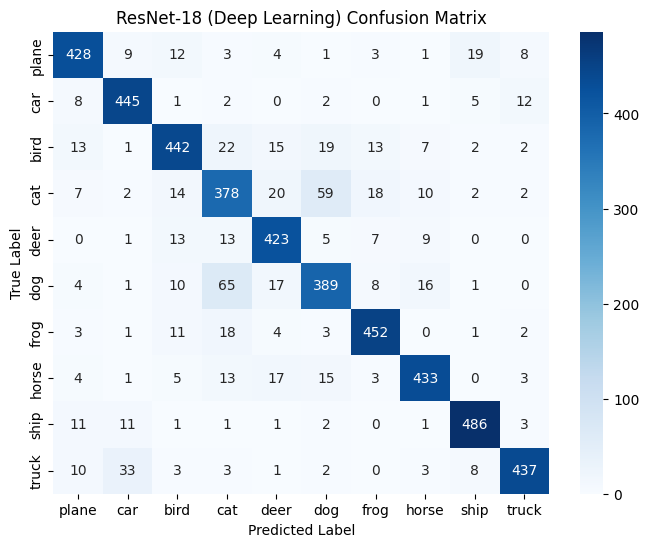


Weighted ROC-AUC Score: 0.9894
------------------------------------------------------------

==================== SVM (Deep Features) Detailed Results ====================
Overall Accuracy: 86.40%

--- Classification Report ---
              precision    recall  f1-score   support

       plane     0.8871    0.9016    0.8943       488
         car     0.9119    0.9139    0.9129       476
        bird     0.8365    0.8302    0.8333       536
         cat     0.7111    0.7500    0.7300       512
        deer     0.8671    0.8726    0.8698       471
         dog     0.8025    0.7476    0.7741       511
        frog     0.9030    0.9030    0.9030       495
       horse     0.8961    0.8907    0.8934       494
        ship     0.9291    0.9381    0.9336       517
       truck     0.9074    0.9020    0.9047       500

    accuracy                         0.8640      5000
   macro avg     0.8652    0.8650    0.8649      5000
weighted avg     0.8643    0.8640    0.8640      5000



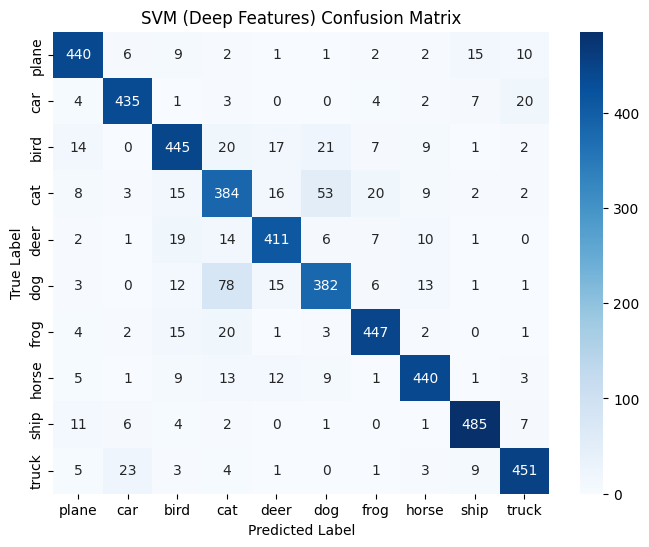


Weighted ROC-AUC Score: 0.9813
------------------------------------------------------------

==================== k-NN (Deep Features) Detailed Results ====================
Overall Accuracy: 86.18%

--- Classification Report ---
              precision    recall  f1-score   support

       plane     0.8880    0.9098    0.8988       488
         car     0.9170    0.9286    0.9228       476
        bird     0.8417    0.8134    0.8273       536
         cat     0.7218    0.7246    0.7232       512
        deer     0.8476    0.8854    0.8660       471
         dog     0.7942    0.7476    0.7702       511
        frog     0.8829    0.8990    0.8909       495
       horse     0.8945    0.8927    0.8936       494
        ship     0.9306    0.9342    0.9324       517
       truck     0.9014    0.8960    0.8987       500

    accuracy                         0.8618      5000
   macro avg     0.8620    0.8631    0.8624      5000
weighted avg     0.8613    0.8618    0.8614      5000



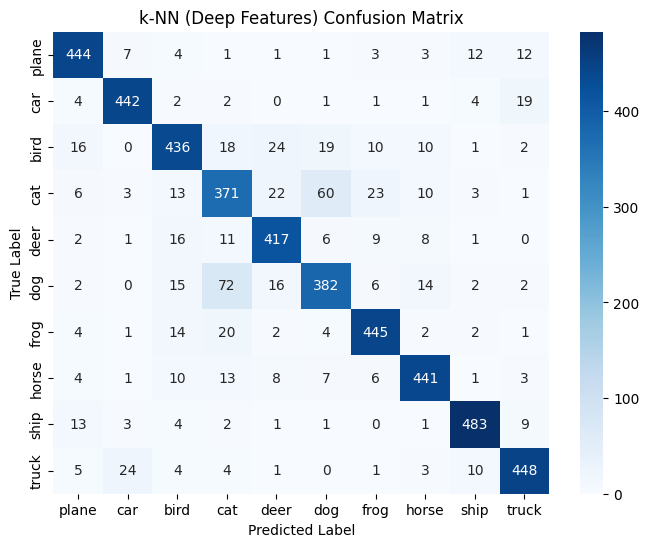


Weighted ROC-AUC Score: 0.9565
------------------------------------------------------------

=== Final Accuracy Summary ===
ResNet-18 Accuracy: 0.8626
SVM Accuracy:       0.8640
k-NN Accuracy:      0.8618


In [ ]:
# --- Cell 6: Detailed Comprehensive Evaluation ---
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
import seaborn as sns

def detailed_evaluation(model_name, y_true, y_pred, y_prob=None):
    print(f"\n{'='*20} {model_name} Detailed Results {'='*20}")

    # 1. Basic Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {acc:.2%}")

    # 2. Detailed Report (Precision, Recall, F1)
    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))

    # 3. Confusion Matrix with TP/FP/FN/TN Analysis
    cm = confusion_matrix(y_true, y_pred)

    # Plotting CM
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # 4. ROC-AUC Score (Multi-class One-vs-Rest)
    if y_prob is not None:
        # Binarize labels for ROC calc
        y_true_bin = label_binarize(y_true, classes=range(10))
        try:
            roc_auc = roc_auc_score(y_true_bin, y_prob, multi_class='ovr', average='weighted')
            print(f"\nWeighted ROC-AUC Score: {roc_auc:.4f}")
        except Exception as e:
            print(f"Could not calc ROC: {e}")

    print("-" * 60)

# --- Run Evaluations ---

# 1. ResNet Evaluation
trained_resnet.eval()
resnet_preds = []
resnet_probs = []
resnet_targets = []
with torch.no_grad():
    for X, y in final_test_loader:
        X = X.to(DEVICE)
        out = trained_resnet(X)
        prob = torch.nn.functional.softmax(out, dim=1)
        _, pred = torch.max(out, 1)
        resnet_preds.extend(pred.cpu().numpy())
        resnet_probs.extend(prob.cpu().numpy())
        resnet_targets.extend(y.numpy())

detailed_evaluation("ResNet-18 (Deep Learning)",
                    np.array(resnet_targets),
                    np.array(resnet_preds),
                    np.array(resnet_probs))

# 2. SVM Evaluation
svm_preds = final_svm.predict(X_test_scaled)
svm_probs = final_svm.predict_proba(X_test_scaled)
detailed_evaluation("SVM (Deep Features)", y_test_deep, svm_preds, svm_probs)

# 3. k-NN Evaluation
knn_preds = final_knn.predict(X_test_scaled)
knn_probs = final_knn.predict_proba(X_test_scaled)
detailed_evaluation("k-NN (Deep Features)", y_test_deep, knn_preds, knn_probs)

# --- Summary Table ---
print("\n=== Final Accuracy Summary ===")
print(f"ResNet-18 Accuracy: {accuracy_score(resnet_targets, resnet_preds):.4f}")
print(f"SVM Accuracy:       {accuracy_score(y_test_deep, svm_preds):.4f}")
print(f"k-NN Accuracy:      {accuracy_score(y_test_deep, knn_preds):.4f}")